# Simple Perceptron Implementation
_by Mihai Dan Nadăș (mihai.nadas@ubbcluj.ro), January 2025_

This notebook implements a version of the perceptron as introduced in Frank Rosenblatt's 1958 paper, "The Perceptron: A Probabilistic Model for Information Storage and Organization in the Brain."

We will utilize basic math concepts, minimizing linear algebra (vectors and matrices) where possible.

## Introduction to the Perceptron

A perceptron is a simple computational model of a neuron. It forms the foundation of neural networks and works by taking weighted inputs and applying a threshold function to produce an output. This notebook showcases how perceptrons can be used for classifying linearly separable data.

## Objective

The objective is to train a model with two weights, $w_1$ and $w_2$, corresponding to the coordinates $x$ and $y$ of a point $(x, y)$, along with a bias $b$. This aligns with the slope-intercept formula of a line, $y = mx + c$.

The model will address a simple classification task on a linearly separable dataset based on the following function:

$
f: \mathbb{N} \to \mathbb{N}, \quad f(x) =
\begin{cases}
x, & \text{if } x \bmod 2 = 0, \\
2x, & \text{if } x \bmod 2 = 1.
\end{cases}
$

## Dataset

We will generate a dataset using the Python Standard Library. The dataset consists of points determined by the function above, classified into two classes. This setup allows us to train our perceptron classifier effectively.

In [19]:
import random


def generate_dataset(num_items=20, start=0, stop=100):
    random.seed(42)
    dataset = []
    x1_values = set()
    while len(dataset) < num_items:
        x1 = random.randint(start, stop)
        if x1 in x1_values:
            continue
        x1_values.add(x1)
        x2 = x1 if x1 % 2 == 0 else 2 * x1
        y = (
            0 if x1 == x2 else 1
        )  # (x1, x2) is labeled as Class 0 if x1 is even, and Class 1 otherwise
        dataset.append((x1, x2, y))
    return dataset


dataset = generate_dataset()

# let's now split the dataset into training and test sets
train_ratio = 0.8
num_train = int(len(dataset) * train_ratio)
dataset_train, dataset_test = dataset[:num_train], dataset[num_train:]
print(f"Training set (n={len(dataset_train)}): {dataset_train}")
print(f"Test set (n={len(dataset_test)}: {dataset_test}")

Training set (n=16): [(81, 162, 1), (14, 14, 0), (3, 6, 1), (94, 94, 0), (35, 70, 1), (31, 62, 1), (28, 28, 0), (17, 34, 1), (13, 26, 1), (86, 86, 0), (69, 138, 1), (11, 22, 1), (75, 150, 1), (54, 54, 0), (4, 4, 0), (27, 54, 1)]
Test set (n=4: [(29, 58, 1), (64, 64, 0), (77, 154, 1), (71, 142, 1)]


## Visual Representation

Using _Matplotlib_ and _pandas_, we will visually represent the training and test datasets. This will help us understand how our data is distributed and observe how the two classes might be separated. Let's proceed by plotting the data points with distinct markers and colors for each class and dataset type.

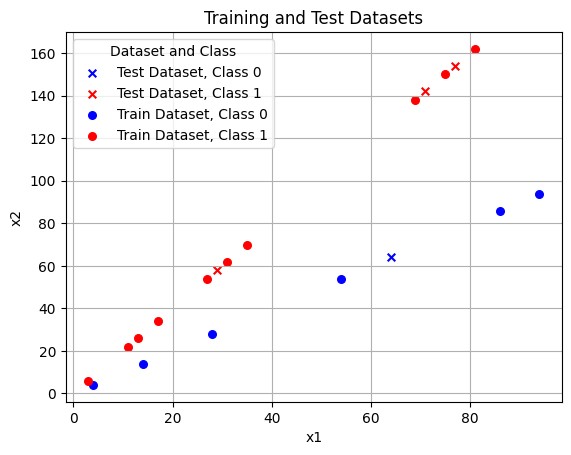

In [20]:
import matplotlib.pyplot as plt
import pandas as pd


def plot_datasets(train_dataset, test_dataset):
    # Combine datasets into a DataFrame for easier handling
    train_df = pd.DataFrame(train_dataset, columns=["x1", "x2", "class"])
    train_df["set"] = "Train"

    test_df = pd.DataFrame(test_dataset, columns=["x1", "x2", "class"])
    test_df["set"] = "Test"

    combined_df = pd.concat([train_df, test_df], ignore_index=True)

    # Define colors and markers
    colors = {0: "blue", 1: "red"}
    markers = {"Train": "o", "Test": "x"}

    # Plot each group using Matplotlib
    fig, ax = plt.subplots()
    for (dataset, cls), group in combined_df.groupby(["set", "class"]):
        ax.scatter(
            group["x1"],
            group["x2"],
            color=colors[cls],
            label=f"{dataset} Dataset, Class {cls}",
            s=30,
            marker=markers[dataset],
        )

    # Manage legend and labels
    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys(), title="Dataset and Class", loc="best")
    ax.set_xlabel("x1")
    ax.set_ylabel("x2")
    ax.set_title("Training and Test Datasets")
    ax.grid(True)


plot_datasets(dataset_train, dataset_test)
plt.show()

## Defining a Linear Classifier

With our dataset prepared, we now focus on the mathematical foundation enabling our model to classify inputs $x_{1}$ and $x_{2}$ into classes $0$ or $1$. Mathematically, this can be represented as:

$
c: \mathbb{R}^2 \to \{0,1\}, \quad
c(x_{1}, x_{2}) =
\begin{cases} 
1, & \text{if } (x_{1}, x_{2}) \in \text{Class 1}, \\
0, & \text{if } (x_{1}, x_{2}) \in \text{Class 2}.
\end{cases}
$

This classification uses the algebraic representation of a line in a Cartesian coordinate system, described by:

$
z(x) = w_{1}x_{1} + w_{2}x_{2} + b,
$

where:
- $w_{1}$ and $w_{2}$ are weights that influence the slope of the line, dictating its angle concerning the $x$-axis.
- $b$ is the bias (or intercept), indicating where the line intersects the $y$-axis.

From the plotted graph above, the two classes are visibly linearly separable, justifying the use of a linear decision boundary. Training the weights $w_{1}$ and $w_{2}$ using the Perceptron algorithm provides an ideal approach to establish this boundary.

To illustrate, consider a line defined by $w_{1}=1$, $w_{2}=0.5$, and $b=0$. This line's appearance on the previous graph helps define how well it separates our classes.

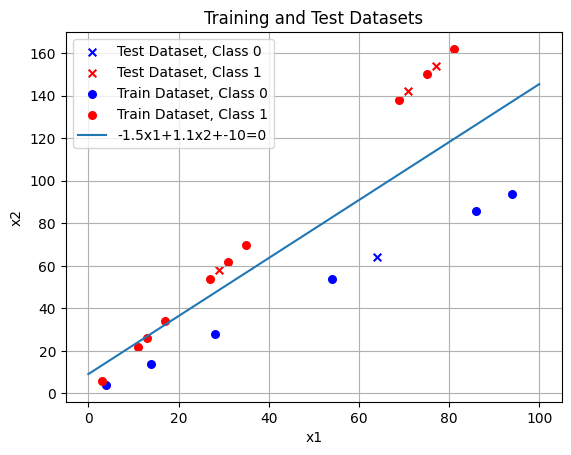

In [21]:
zx = lambda x1, x2, w1, w2, c: w1 * x1 + w2 * x2 + c


def plot_zx(w1, w2, c):
    x2 = lambda x1: (
        (-w1 * x1 - c) / w2 if w2 != 0 else -c / w1 if w1 != 0 else c
    )  # this is because the equation of the line is w1*x1 + w2*x2 + c = 0, hence x2 = (-w1*x1 - c) / w2
    x1_values = range(0, 101)
    x2_values = [x2(x1) for x1 in x1_values]
    plt.plot(x1_values, x2_values, label=f"{w1}x1+{w2}x2+{c}=0")
    plt.legend(loc="best")


def plot_datasets_and_zx(w1, w2, c):
    plot_datasets(dataset_train, dataset_test)
    plot_zx(w1, w2, c)


plot_datasets_and_zx(-1.5, 1.1, -10)

In this configuration, the data points are separated neatly by the decision boundary. However, there are alternative configurations for $w_{1},\ w_{2},$ and $c$ that result in less optimal separation. For instance, setting $w_{1}=0.1,\ w_{2}=0.1,$ and $c=0.5$ results in a less effective decision boundary.

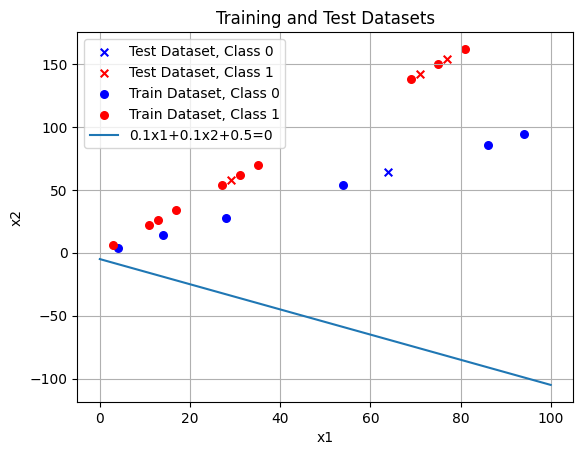

In [22]:
plot_datasets_and_zx(0.1, 0.1, 0.5)

In this particular case, $z$ will not help classify any data points effectively.

## Evaluating the Performance of the Classifier

With $z = w_{1}x_{1} + w_{2}x_{2} + c$ defined as our classifier's decision boundary, we've seen visually that it can classify using certain hand-picked values. Now, let's computationally determine its performance using the _accuracy_ metric.

### Defining the Classifier

Before evaluating the classifier's performance, let's clearly define it:

$
c: \mathbb{N} \times \mathbb{N} \to \{0,1\}, \quad
c(x_{1},x_{2}) =
\begin{cases} 
1, & \text{if } z(x_{1}, x_{2}) \geq 0, \\
0, & \text{if } z(x_{1}, x_{2}) < 0.
\end{cases}
$

In essence, this means if a point $(x_1, x_2)$ is on or above the decision boundary $z(x_1, x_2)$, it is classified as $1$ (Class 1); otherwise, it is classified as $0$ (Class 0).

Let's implement the classifier in code, and then discuss how we can evaluate its performance effectively.

In [23]:
cx = lambda x1, x2, w1, w2, c: 1 if zx(x1, x2, w1, w2, c) >= 0 else 0


def accuracy(dataset, w1, w2, c):
    print(f"Calculating accuracy on training set using w1={w1}, w2={w2}, c={c}")
    correct = 0
    for x1, x2, y in dataset:
        if y == cx(x1, x2, w1, w2, c):
            correct += 1
    print(
        f"Resulting accuracy: {correct}/{len(dataset)}, or {correct/len(dataset)*100:.2f}%"
    )
    return correct / len(dataset)


# Applying the accuracy function to the training set using the two sets of weights and bias as shown above, in the first example
accuracy(dataset_train, -1.5, 1.1, -10)

# Applying the accuracy function to the training set using two sets of weights and bias as shown above, in the second example
accuracy(dataset_train, 0.1, 0.1, 0.5)

Calculating accuracy on training set using w1=-1.5, w2=1.1, c=-10
Resulting accuracy: 13/16, or 81.25%
Calculating accuracy on training set using w1=0.1, w2=0.1, c=0.5
Resulting accuracy: 10/16, or 62.50%


0.625

### Discussion on Accuracy

Earlier, we observed how modifying the weights and bias affects the accuracy of our perceptron model. This variation occurs because each set of weights and bias defines a unique decision boundary, which impacts the model's ability to classify data points correctly. The primary goal is to determine the "optimal" values for these parameters, a process achieved through _model training_.

## Model Training

Based on our analysis, we will train our perceptron model iteratively, fine-tuning the weights and bias. This training involves adjustment over multiple epochs—learning cycles through the dataset—allowing the model to incrementally improve accuracy. The idea is to iteratively update these parameters to better suit our classification task and dataset characteristics, ultimately enhancing the model's overall performance.

In [24]:
# First, let's initialize the weights and bias to zero
w1, w2, c = 0, 0, 0

# Let's now define the learning rate
learning_rate = 0.1

# Let's now define the number of epochs
num_epochs = 5

# Create a DataFrame to store the details of the epochs
epoch_data = []

# Let's now start the training loop
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}")
    error = 0
    for x1, x2, y in dataset_train:
        z = zx(x1, x2, w1, w2, c)
        y_hat = 1 if z >= 0 else 0
        if y != y_hat:
            error += 1 # Count the number of errors
        w1 += learning_rate * (y - y_hat) * x1
        w2 += learning_rate * (y - y_hat) * x2
        c += learning_rate * (y - y_hat)
        print(f"  x1={x1}, x2={x2}, y={y}, z={z:.2f}, y_hat={y_hat}, w1={w1:.2f}, w2={w2:.2f}, c={c:.2f}")
        # Append the details to the DataFrame
    epoch_data.append({
        "epoch": epoch + 1,
        "x1": x1,
        "x2": x2,
        "y": y,
        "z": z,
        "y_hat": y_hat,
        "w1": w1,
        "w2": w2,
        "c": c,
        "err": error
    })
epoch_details = pd.DataFrame(epoch_data)

# Display the DataFrame
epoch_details.head()

Epoch 1
  x1=81, x2=162, y=1, z=0.00, y_hat=1, w1=0.00, w2=0.00, c=0.00
  x1=14, x2=14, y=0, z=0.00, y_hat=1, w1=-1.40, w2=-1.40, c=-0.10
  x1=3, x2=6, y=1, z=-12.70, y_hat=0, w1=-1.10, w2=-0.80, c=0.00
  x1=94, x2=94, y=0, z=-178.60, y_hat=0, w1=-1.10, w2=-0.80, c=0.00
  x1=35, x2=70, y=1, z=-94.50, y_hat=0, w1=2.40, w2=6.20, c=0.10
  x1=31, x2=62, y=1, z=458.90, y_hat=1, w1=2.40, w2=6.20, c=0.10
  x1=28, x2=28, y=0, z=240.90, y_hat=1, w1=-0.40, w2=3.40, c=0.00
  x1=17, x2=34, y=1, z=108.80, y_hat=1, w1=-0.40, w2=3.40, c=0.00
  x1=13, x2=26, y=1, z=83.20, y_hat=1, w1=-0.40, w2=3.40, c=0.00
  x1=86, x2=86, y=0, z=258.00, y_hat=1, w1=-9.00, w2=-5.20, c=-0.10
  x1=69, x2=138, y=1, z=-1338.70, y_hat=0, w1=-2.10, w2=8.60, c=0.00
  x1=11, x2=22, y=1, z=166.10, y_hat=1, w1=-2.10, w2=8.60, c=0.00
  x1=75, x2=150, y=1, z=1132.50, y_hat=1, w1=-2.10, w2=8.60, c=0.00
  x1=54, x2=54, y=0, z=351.00, y_hat=1, w1=-7.50, w2=3.20, c=-0.10
  x1=4, x2=4, y=0, z=-17.30, y_hat=0, w1=-7.50, w2=3.20, c=-0.10

,epoch,x1,x2,y,z,y_hat,w1,w2,c,err
0,1,27,54,1,-29.8,0,-4.8,8.6,0.0,8
1,2,27,54,1,124.1,1,-11.8,8.2,-0.1,5
2,3,27,54,1,124.1,1,-11.8,8.2,-0.1,0
3,4,27,54,1,124.1,1,-11.8,8.2,-0.1,0
4,5,27,54,1,124.1,1,-11.8,8.2,-0.1,0


### Interpreting the Results

After training our model, let's examine the results. Notice how the weights $w_1$ and $w_2$, along with the bias $c$, change with each epoch. These adjustments demonstrate the perceptron's learning as it becomes more adept at classifying data points. Each iteration helps minimize classification errors, thereby enhancing the model's predictive accuracy.

We track misclassified points per epoch to gauge the learning process. The `err` column in the DataFrame shows this progression. As the model learns, misclassifications decline—a sign that it's improving at distinguishing between the data points. Remarkably, by the end of the second epoch, the model accurately classifies all points.

## Visualizing the Decision Boundary

With the finalized weights and bias, we can plot the decision boundary—a line modeled by the equation $z = w_{1}x_{1} + w_{2}x_{2} + c$. This plot illustrates how the perceptron separates different classes in the dataset. Interactive visualizations below enhance understanding by showing how tweaks in weights and bias affect the decision boundary.

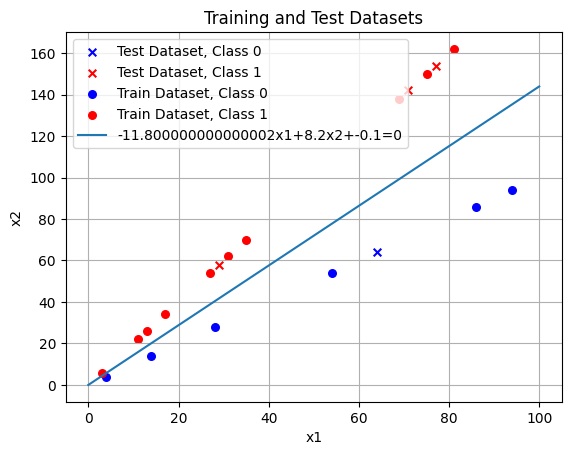

In [25]:
plot_datasets_and_zx(w1, w2, c)

As we can see, the decision boundary effectively separates the two classes in the dataset, indicating that the model has learnt to classify the data points based on the values of $w_{1}$, $w_{2}$, and $c$. Isn't that fascinating?

## Interactive Visualization
To reinforce this understanding, let's build an interactive visualization. This will allow us to see how altering the weights and the bias shifts the decision boundary. Such an interactive component will enhance our grasp of how the model distinguishes between the two classes.

In [26]:
from ipywidgets import interact

trained_w1 = w1
trained_w2 = w2
trained_c = c
print(f"Trained weights: w1={trained_w1}, w2={trained_w2}, c={trained_c}")

def plot_dynamic_line(w1=trained_w1, w2=trained_w2, c=trained_c):
    plot_datasets(dataset_train, dataset_test)
    plot_zx(w1, w2, c)

# This will display an interactive plot that allows you to change the weights and bias. The default values are the trained weights and bias.
interact(plot_dynamic_line, w1=(-20, 20, 0.5), w2=(-20, 20, 0.5), c=(-50, 50, 0.5))

Trained weights: w1=-11.800000000000002, w2=8.2, c=-0.1


interactive(children=(FloatSlider(value=-11.800000000000002, description='w1', max=20.0, min=-20.0, step=0.5),…

<function __main__.plot_dynamic_line(w1=-11.800000000000002, w2=8.2, c=-0.1)>

Play with the "knobs" $w_1, w_2$, and $c$ to see how the decision boundary changes. As you adjust the weights and bias, the line's position and angle will change, offering a hands-on way to visualize how the model makes classifications based on these parameters.

# Conclusion
This notebook presented an introductory implementation of a perceptron model with a focus on young learners. We generated and visualized a dataset, developed a linear classifier, evaluated its performance, and iteratively trained the model to refine its accuracy. By analyzing the performance improvements, it became evident that the error rate decreased over time, highlighting the model’s capability to learn effectively by the second epoch.

## Limitations and Future Work
Though the perceptron is effective for linearly separable data, it struggles with datasets that can't be divided by a single straight line. For non-linearly separable data, more complex models are required. Future endeavors might include exploring:

- The Adaptive Linear Neuron (Adaline), leveraging continuous linear activations.
- Logistic regression models using sigmoid activations.
- Multi-layer Perceptrons (MLPs) for more complex datasets.
- Convolutional Neural Networks (CNNs) for image data.
- Recurrent Neural Networks (RNNs) for sequence data.
- Generative Adversarial Networks (GANs) for creating data samples.
- Transformer models for diverse natural language processing tasks including encoder-only, decoder-only, and encoder-decoder configurations.

These projects promise further learning and exploration, so stay tuned for future advancements!